In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os,random,time
from keras.layers import Input,Conv2D, AveragePooling2D, GlobalAveragePooling2D, Activation, Dropout, Add,Flatten, Dense, MaxPooling2D
from keras.preprocessing.image import load_img,img_to_array,ImageDataGenerator
from keras.models import Sequential,Model,model_from_json
from keras.optimizers import SGD
from keras.applications.vgg16 import VGG16
from keras.utils import to_categorical

Using TensorFlow backend.


In [2]:
train_datagen = ImageDataGenerator(
    rescale = 1.0/255,
    width_shift_range = 0.2,
    channel_shift_range = 100)

valid_datagen = ImageDataGenerator(rescale = 1.0/255)

In [3]:
classes = {'000_RIGHT','001_LEFT','002_SQUAT','003_STOP','004_JUMP','005_FIRE'}

img_rows, img_cols = 224, 224
batch_size = 32

train_generator = train_datagen.flow_from_directory(
    directory = 'data/train',
    target_size = (img_rows, img_cols),
    class_mode = 'categorical',
    batch_size = batch_size,
    shuffle = True)

valid_generator = valid_datagen.flow_from_directory(
    directory='data/valid',
    target_size=(img_rows, img_cols),
    class_mode='categorical',
    batch_size= batch_size,
    shuffle=True)

Found 7121 images belonging to 6 classes.
Found 1459 images belonging to 6 classes.


In [91]:
nb_classes = 6
base_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=(224,224,3)))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024,activation = 'relu')(x)
x = Dropout(0.96)(x)
prediction = Dense(nb_classes,activation = 'softmax')(x)

model = Model(inputs = base_model.input, outputs = prediction)

for layer in model.layers[:15]:
    layer.trainable = False
    
#model.load_weights('9596.h5')

model.compile(loss = 'categorical_crossentropy',
             optimizer = SGD(lr = 1e-3, momentum = 0.9),
             metrics = ['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [92]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch= int((5232-1)/batch_size) + 1,
    validation_data=valid_generator,
    validation_steps = int((1392-1)/batch_size) + 1,
    epochs= 100,
    initial_epoch = 20
    )

Epoch 21/100
164/164 [==============================] - 142s 868ms/step - loss: 1.8406 - acc: 0.1948 - val_loss: 1.7754 - val_acc: 0.1309
Epoch 22/100
164/164 [==============================] - 135s 821ms/step - loss: 1.7291 - acc: 0.2133 - val_loss: 1.6336 - val_acc: 0.2783
Epoch 23/100
164/164 [==============================] - 135s 821ms/step - loss: 1.5959 - acc: 0.2849 - val_loss: 1.4853 - val_acc: 0.3400
Epoch 24/100
164/164 [==============================] - 134s 816ms/step - loss: 1.5455 - acc: 0.2847 - val_loss: 1.4527 - val_acc: 0.3331
Epoch 25/100
164/164 [==============================] - 133s 809ms/step - loss: 1.5319 - acc: 0.2899 - val_loss: 1.4247 - val_acc: 0.3523
Epoch 26/100
164/164 [==============================] - 134s 814ms/step - loss: 1.5053 - acc: 0.3228 - val_loss: 1.4727 - val_acc: 0.3660
Epoch 27/100
164/164 [==============================] - 132s 802ms/step - loss: 1.4444 - acc: 0.3680 - val_loss: 1.3635 - val_acc: 0.3927
Epoch 28/100
164/164 [============

In [1]:
plt.plot(history.history["acc"])
plt.plot(history.history["val_acc"])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['acc','val_acc'],loc = 'lower right')
plt.ylim(0,1)

NameError: name 'plt' is not defined

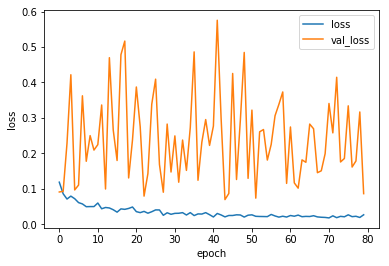

In [86]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['loss','val_loss'],loc = 'upper right')

In [87]:
open('9767.json',"w").write(model.to_json())

11794

In [88]:
model.save_weights('9767.h5')


 test loss: 0.08630620943233064

 test_acc: 0.9766963676608859


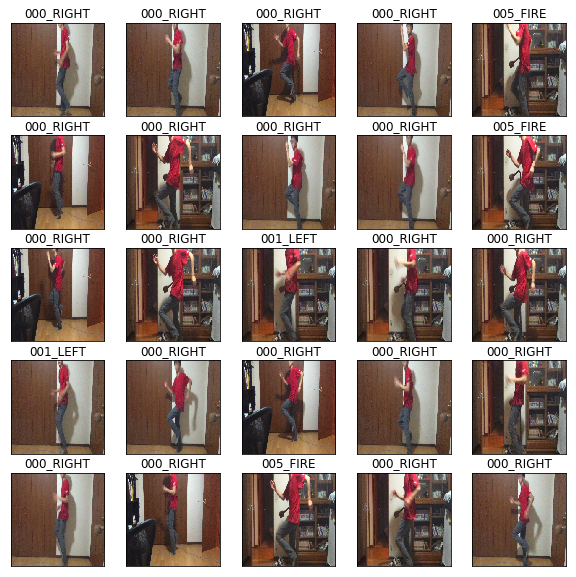

In [90]:
batch_size=32
file_name='9767'
display_dir='data/valid/000_RIGHT'
test_dir = 'data/valid'
label = ['000_RIGHT','001_LEFT','002_SQUAT','003_STOP','004_JUMP','005_FIRE']

#load model and weights
json_string=open(file_name+'.json').read()
model=model_from_json(json_string)
model.load_weights(file_name+'.h5')

model.compile(optimizer=SGD(lr=1e-4,momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


#evaluate model
score=model.evaluate_generator(valid_generator)
print('\n test loss:',score[0])
print('\n test_acc:',score[1])

#predict model and display images
files=os.listdir(display_dir)
img=random.sample(files,len(files))

plt.figure(figsize=(10,10))
for i in range(25):
    temp_img=load_img(os.path.join(display_dir,img[i+50]),target_size=(224,224))
    plt.subplot(5,5,i+1)
    plt.imshow(temp_img)
    #Images normalization
    temp_img_array=img_to_array(temp_img)
    temp_img_array=temp_img_array.astype('float32')/255.0
    temp_img_array=temp_img_array.reshape((1,224,224,3))
    #predict image
    img_pred=model.predict(temp_img_array)
    plt.title(label[np.argmax(img_pred)])
    #eliminate xticks,yticks
    plt.xticks([]),plt.yticks([])


plt.show()